# baseline от команды г

#### *настройка ноутбука*

In [1]:
#!pip install jupyterthemes # - импорт библиотеки для настройки тем
#!chcp 65001 # - смена кодировки
#!jt -t monokai -T -N -kl # - выбираем темную нужную мне тему
#!jt -l # - показ всех тем
#!jt -r # - возврат к базовой теме

#### *необходимые настройки или скачивания для библиотек*

In [2]:
#!pip install lightgbm
#!pip install fastparquet
#!pip install pandas==0.25
#!pip install --upgrade pandas
#!pip install --upgrade scipy
#!pip install --upgrade pandas "dask[complete]"

#### *наши библиотеки*

In [3]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, cv

## *Загрузка данных*

In [4]:
pd.io.parquet.get_engine('auto')

In [5]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [6]:
train_df.head()

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,0,48.871217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.064993,33196.020871,1.229488,0.396969,323523.957625,12.420855,9.069157,1,1,1
1,1,19.530576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.270542,33195.488147,1.229488,-0.137339,145641.572203,2.124925,2.069157,0,0,0
2,2,9.706201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.431839,265071.236918,4.229488,3.595162,125727.062161,0.999583,1.069157,0,0,0
3,3,92.569902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.990581,495094.276542,9.229488,8.582252,370392.322955,3.066714,3.069157,0,0,0
4,4,26.538856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393927,33196.317418,1.229488,0.276606,125726.775788,1.219935,1.069157,0,0,0


#### *есть два таргета*
> ##### *1 - прекращение финансовой активности*
> ##### *2 - закрытие РКО*
>> итоговый таргет это максимум из первых двух, глянем распределение значений и заметим, что чаще люди прекращают активность(почти очевидно) 

In [7]:
train_df['target_1'].value_counts()

target_1
0    340359
1     19641
Name: count, dtype: int64

In [8]:
train_df['target_2'].value_counts()

target_2
0    350524
1      9476
Name: count, dtype: int64

#### *есть два стула удалять или нет города:*
>##### * с одной стороны там много инфы в целых 3 колонках("city", "city_type", "index_city_code")
>##### * с другой очень много NaN (я бы оставил индекс, но с какими-то правками внутри него или нет)
##### з.ы. в этой версии я их удалю

In [9]:
len(train_df.columns)

103

In [10]:
train_df = train_df.drop(['city', 'index_city_code', 'city_type'], axis=1)
len(train_df.columns)

100

#### *попробуем обработать все колонки, которые вынесены в категории*
> - *города удалили*
> - *сегмент я бы оставил, а все NaN заполняем просто нулями*
> - *ОГРН месяц для меня не особо важно поэтому тоже удалим т.к. это просто месяц, который несет мало информации в себе*
> - *ОГРН год вот это я бы оставил(на самом деле удалю т.к. считаю, что необходимая инфа для модели берется из другой статистики по месяцам и год мало влияет)*
> - *код канала странная колонка, её удалю*
> - *код отделения точно удаляю*
> - *ОКВЭД оставляем это важно*

##### *как итог удаляем все кроме ОКВЭД и сегмента, все NaN заполняем самым популярным значением из этих колонок(как вариант их можно оставить как категории и преобразить, но сейчас я просто их сделаю float64)*

In [11]:
len(train_df.columns)

100

In [12]:
columns = ['segment', 'okved']
train_df[columns] = train_df[columns].astype("float64")
train_df['segment'].dtype

dtype('float64')

In [13]:
exp1 = train_df['segment'].value_counts().sum() == len(train_df)
exp2 = train_df['okved'].value_counts().sum() == len(train_df)
exp1 or exp2

False

In [14]:
train_df['segment'] = train_df['segment'].fillna(train_df['segment'].value_counts().index[0])
train_df['okved'] = train_df['okved'].fillna(train_df['okved'].value_counts().index[0])

In [15]:
exp1 = train_df['segment'].value_counts().sum() == len(train_df)
exp2 = train_df['okved'].value_counts().sum() == len(train_df)
exp1 and exp2

True

In [16]:
len(train_df.columns)

100

In [17]:
train_df = train_df.drop(['channel_code', 'ogrn_month', 
                          'ogrn_year', 'branch_code'], axis=1)
len(train_df.columns)

96

##### *все четко по длине теперь, ну и удалили ненужное*

##### ну что время для корреляции??(пока что отбросим все таргеты и id)

In [18]:
y = train_df.total_target
train_df = train_df.drop(["id", "target_1", "target_2", "total_target"], axis=1)

In [19]:
import seaborn as sns

<Axes: >

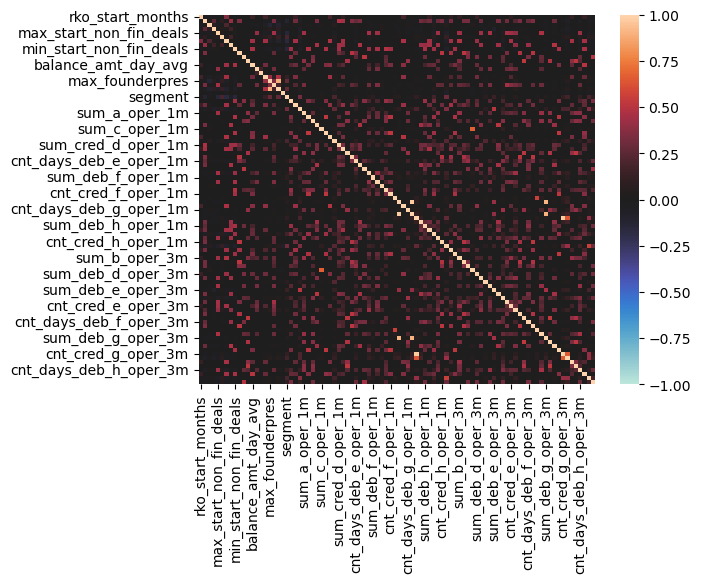

In [20]:
sns.heatmap(train_df.corr(), vmin=-1, vmax=1, center= 0)

##### мда мало понятного, но сейчас говнокодом постараюсь вывести все нормально

In [21]:
first = list(train_df.columns)
first[:5]

['rko_start_months',
 'max_end_fact_fin_deals',
 'max_end_plan_non_fin_deals',
 'max_start_fin_deals',
 'max_start_non_fin_deals']

In [22]:
%%time
corr_matrix = train_df.loc[:,:].corr()

CPU times: total: 7.11 s
Wall time: 15.8 s


In [23]:
corr = corr_matrix.to_numpy()

In [24]:
len(first)

92

In [25]:
help_me = []
for i in range((len(first))):
    for j in range(len(first)):
        if i!=j and [first[j], first[i], corr[j, i]] not in help_me:
            help_me.append([first[i], first[j], corr[i, j]])

In [26]:
len(help_me)

4186

In [27]:
sorted(help_me, key=lambda x: x[2])[-15:]

[['cnt_a_oper_1m', 'cnt_c_oper_1m', 0.5167170913604409],
 ['balance_amt_min', 'cnt_deb_f_oper_3m', 0.5180420824290729],
 ['cnt_c_oper_1m', 'cnt_cred_f_oper_1m', 0.5196510516078735],
 ['cnt_a_oper_3m', 'sum_cred_g_oper_3m', 0.5217379354814423],
 ['cnt_deb_f_oper_3m', 'cnt_deb_g_oper_3m', 0.527875735720927],
 ['cnt_days_cred_f_oper_1m', 'cnt_cred_f_oper_3m', 0.5556353546617487],
 ['cnt_days_cred_h_oper_1m', 'cnt_cred_h_oper_3m', 0.5623641256690128],
 ['cnt_cred_g_oper_1m', 'cnt_days_cred_g_oper_3m', 0.6350778159861407],
 ['cnt_cred_g_oper_3m', 'cnt_days_cred_g_oper_3m', 0.6481092726126781],
 ['sum_c_oper_1m', 'cnt_c_oper_3m', 0.6698969333043825],
 ['max_founderpres', 'ogrn_exist_months', 0.8967734335527877],
 ['sum_cred_g_oper_1m', 'sum_deb_g_oper_3m', 0.9005993725874963],
 ['sum_deb_g_oper_1m', 'sum_deb_g_oper_3m', 0.9074554693992195],
 ['cnt_cred_g_oper_1m', 'cnt_cred_g_oper_3m', 0.9701495944576674],
 ['sum_deb_g_oper_1m', 'sum_cred_g_oper_1m', 0.9741765115545096]]

##### *плохо?? да*
> #####  *зато мы видим что можно удалить:*
> * #####  *max_founderpres или ogrn_exist_months*
> * ##### *cnt_cred_g_oper_1m или cnt_cred_g_oper_3m*
> * ##### *sum_cred_g_oper_1m или sum_deb_g_oper_3m* 
> * ##### *sum_deb_g_oper_1m или sum_deb_g_oper_3m*
> * ##### *sum_deb_g_oper_1m или sum_cred_g_oper_1m* 



##### итак удаляем:
> * ##### *ogrn_exist_months*
> * ##### *sum_deb_g_oper_3m*
> * ##### *sum_cred_g_oper_1m*
##### *получается какая-то вилка где точно теряется 1 признак просто так, ну и ладно*

In [28]:
len(train_df.columns)

92

In [29]:
train_df = train_df.drop(["ogrn_exist_months", "sum_deb_g_oper_3m", "sum_cred_g_oper_1m"], axis=1)
len(train_df.columns)

89

##### также есть наитие что все данные по операциям за 1 месяц играют маловажную роль

In [30]:
train_df.head()

,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,balance_amt_avg,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
0,48.871217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27046.725915,...,0.515331,1.186720e+01,-0.354446,0.064993,33196.020871,1.229488,0.396969,323523.957625,12.420855,9.069157
1,19.530576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54167.143820,...,0.497933,1.204940e+01,0.358222,0.270542,33195.488147,1.229488,-0.137339,145641.572203,2.124925,2.069157
2,9.706201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292152.446430,...,23.154435,6.374099e+06,29.426595,23.431839,265071.236918,4.229488,3.595162,125727.062161,0.999583,1.069157
3,92.569902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142491.809620,...,9.378362,1.153105e+01,0.074660,0.990581,495094.276542,9.229488,8.582252,370392.322955,3.066714,3.069157
4,26.538856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72832.525309,...,1.944106,1.232242e+01,0.447267,0.393927,33196.317418,1.229488,0.276606,125726.775788,1.219935,1.069157


#### *быстренько вспомним что делал и проделаем ещё раз с тестом :(*

In [31]:
set1 = set(list(test_df.columns))
set2 = set(list(train_df.columns))
answ = list(set1 - set2)
answ

['ogrn_month',
 'ogrn_exist_months',
 'ogrn_year',
 'sum_deb_g_oper_3m',
 'id',
 'index_city_code',
 'city_type',
 'channel_code',
 'branch_code',
 'city',
 'sum_cred_g_oper_1m']

In [32]:
len(test_df.columns) == len(train_df.columns)

False

In [33]:
test_df = test_df.drop(answ, axis=1)
len(test_df.columns) == len(train_df.columns)

True

#### *вроде ничего не забыли идем дальше*

## Разбиение на train, validation

In [34]:
X = train_df
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Обучение базовой модели

![](https://memepedia.ru/wp-content/uploads/2021/06/mem-based-4.jpg)

In [35]:
cat1 = CatBoostClassifier(learning_rate=0.1, random_state=42, metric_period=100)

In [36]:
cat1.fit(x_train, y_train)

0:	learn: 0.5632493	total: 247ms	remaining: 4m 6s
100:	learn: 0.1703251	total: 16.8s	remaining: 2m 29s
200:	learn: 0.1644886	total: 32.3s	remaining: 2m 8s
300:	learn: 0.1595852	total: 47.2s	remaining: 1m 49s
400:	learn: 0.1553680	total: 1m 2s	remaining: 1m 33s
500:	learn: 0.1514949	total: 1m 19s	remaining: 1m 18s
600:	learn: 0.1478896	total: 1m 37s	remaining: 1m 4s
700:	learn: 0.1445393	total: 1m 56s	remaining: 49.6s
800:	learn: 0.1410722	total: 2m 16s	remaining: 33.9s
900:	learn: 0.1379112	total: 2m 34s	remaining: 17s
999:	learn: 0.1347937	total: 2m 55s	remaining: 0us


In [37]:
model = LGBMClassifier(verbosity=-1, random_state=42)
model.fit(x_train, y_train)

LGBMClassifier(random_state=42, verbosity=-1)

#### *сравним рез-ты моделек*

In [38]:
y_pred = model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8944863851987939

In [39]:
y_pred = cat1.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8991214426476521

In [40]:
y_pred = cat1.predict_proba(x_val)[:, 1] + model.predict_proba(x_val)[:, 1]
y_pred = y_pred / 2
roc_auc_score(y_val, y_pred)

0.8998616798823662

## Выгрузка результатов

In [41]:
columns = ['segment', 'okved']
test_df[columns] = test_df[columns].astype("float64")

In [42]:
test_score = cat1.predict_proba(test_df)[:, 1]
check = model.predict_proba(test_df)[:, 1]

In [43]:
test_score  = check + test_score
test_score = test_score / 2

In [45]:
sample_submission_df = pd.read_csv("sample_submission.csv")
sample_submission_df["score"] = test_score

In [46]:
sample_submission_df.head()
sample_submission_df.to_csv("cat08733.csv", index=False)

![](https://tlgrm.ru/_/stickers/486/e1b/486e1bb2-65ca-47ec-9ebe-6ccbdac7e3d3/4.webp)